In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 90ms/step - loss: 0.1721 - val_loss: 0.0352
Epoch 2/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0205 - val_loss: 0.0384
Epoch 3/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0107 - val_loss: 0.0160
Epoch 4/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 5/100
16/16 [==============================] - 1s 61ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 4.6293e-04 - val_loss: 0.0012
Epoch 7/100
16/16 [==============================] - 1s 55ms/step - loss: 4.2808e-04 - val_loss: 0.0013
Epoch 8/100
16/16 [==============================] - 1s 55ms/step - loss: 3.8157e-04 - val_loss: 0.0013
Epoch 9/100
16/16 [==============================] - 1s 57ms/step - loss: 3.7007e-04 - val_loss: 0.0014
Epoch 10/100
16/16 [==============================] - 1s 84ms/step - loss: 3.6657e-0

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 16ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 25373.2314538393


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99924306645289
Testing MAE: 19981.48485095015


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.07501978427171707], [0.073517806828022], [0.07140308618545532], [0.06905391067266464], [0.06659392267465591], [0.0640668123960495], [0.06148948520421982], [0.0588691383600235], [0.056209005415439606], [0.05351053178310394], [0.050774380564689636], [0.0480007529258728], [0.045189715921878815], [0.04234113544225693], [0.0394548736512661], [0.03653072565793991], [0.03356847167015076], [0.03056788258254528], [0.027528701350092888], [0.024450697004795074], [0.021333616226911545], [0.018177218735218048], [0.014981284737586975], [0.01174557488411665], [0.008469883352518082], [0.005153996869921684], [0.0017977198585867882], [-0.0015991292893886566], [-0.0050367191433906555], [-0.008515208959579468], [-0.01203475147485733], [-0.015595454722642899], [-0.01919744536280632], [-0.022840814664959908], [-0.026525644585490227], [-0.030251989141106606], [-0.03401990234851837], [-0.03782941401004791], [-0.04168049991130829], [-0.04557318240404129], [-0.04950740933418274], [-0.05348309874534607], [-0

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[ 16410.32460526],
       [ 16286.98822549],
       [ 16113.3358252 ],
       [ 15920.4309288 ],
       [ 15718.42655435],
       [ 15510.91036671],
       [ 15299.27056703],
       [ 15084.09816557],
       [ 14865.65868869],
       [ 14644.0708279 ],
       [ 14419.38903445],
       [ 14191.62982726],
       [ 13960.79871264],
       [ 13726.88467798],
       [ 13489.87640475],
       [ 13249.75706813],
       [ 13006.50861967],
       [ 12760.11224615],
       [ 12510.54684006],
       [ 12257.79343525],
       [ 12001.83123009],
       [ 11742.64049366],
       [ 11480.20317751],
       [ 11214.49962718],
       [ 10945.51294138],
       [ 10673.22560697],
       [ 10397.62156391],
       [ 10118.68589927],
       [  9836.40477082],
       [  9550.76510108],
       [  9261.75434789],
       [  8969.36364   ],
       [  8673.58257659],
       [  8374.40366297],
       [  8071.82016922],
       [  7765.82765969],
       [  7456.42169875],
       [  7143.59983915],
       [  68

In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(466,)


(466, 1)

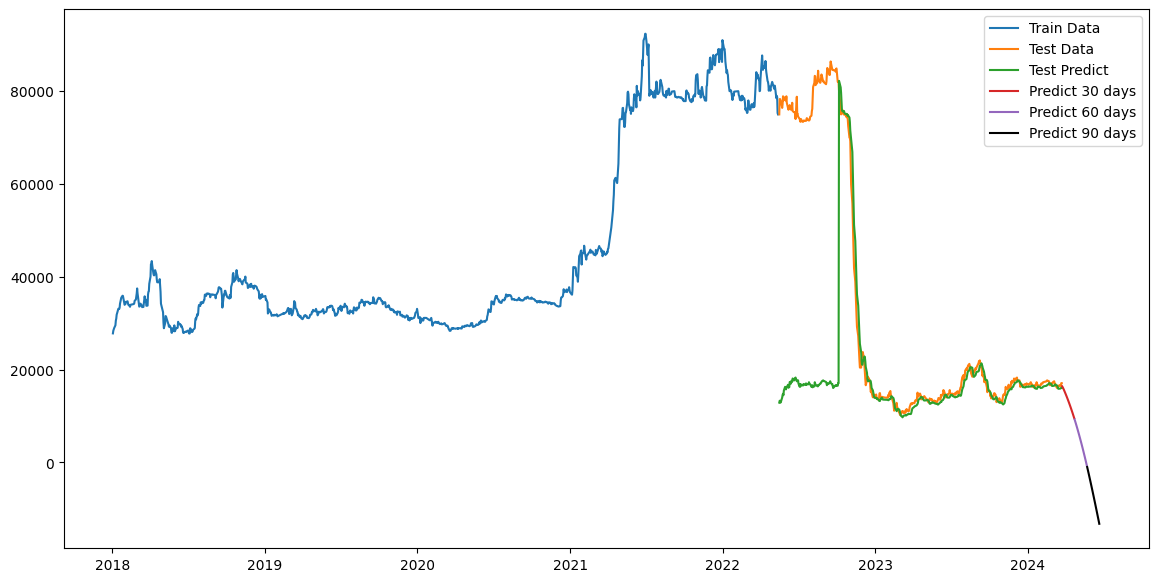

In [19]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()